# Tutorial 1.c.1 Conformal (Interval) Prediction: From any Prediction to Valid Intervals

## 1. Offline Conformal Prediction


One of the basic requirement for an interval prediction is **coverage**. For example, an interval prediction has 95\% coverage if the true label belongs to the predicted interval for 95\% of the samples. In this tutorial we will show how to generate interval predictions with provably correct coverage. In particular, we assume we also have some type of prediction (it could be any type of predictions such as point/ensemble), and we would like to transform such predictions into interval predictions.  

The technique we use is called conformal prediction. We will focus on how to use conformal prediction (rather than how it works, which are introduced in many tutorials such as [SV](https://jmlr.csail.mit.edu/papers/volume9/shafer08a/shafer08a.pdf) or [AB](https://people.eecs.berkeley.edu/~angelopoulos/blog/posts/gentle-intro/)). We will think of conformal prediction as a (black box) algorithm that take as input a batch of original predictions (that can be any type including ensembles) and outputs a batch of interval predictions. Of course, there is no magic without data --- conformal prediction algorithm needs to a batch of labeled validation data (i.e. a batch of original prediction / label pair). However, conformal prediction is extremely data efficient, and typically only require less than 50 samples (unless we want extremely high coverage). 

The main workhorse for conformal prediction is the class ``torchuq.transform.conformal.ConformalIntervalPredictor``. We first import it the class, as well as some test prediction data (same as tutorial 1.a). 

In [1]:
# As before we first setup the environment and load the test prediction
import sys
sys.path.append('../..')   # Include the directory that contains the torchuq package
import torch  
from matplotlib import pyplot as plt

reader = torch.load('pretrained/boston_pretrained.tar')  # Load the pretrained predictions

# Split the data into validation and test, in this example we will use quantile predictions as the original predictions
val_preds = reader['predictions_quantile'][:50]
val_labels = reader['labels'][:50]   # Load the true label (i.e. the ground truth housing prices)
test_preds = reader['predictions_quantile'][50:]
test_labels = reader['labels'][50:]  # Used for testing

from torchuq.transform.conformal import ConformalIntervalPredictor

To use ``ConformalIntervalPredictor`` there are only three functions that you need to know  

1. Constructor: ``calibrator = ConformalIntervalPredictor(input_type='quantile')``, there is only one required argument, which is the prediction type, it is one of the types introduced in tutorial 1.a.

2. Train: ``ConformalIntervalPredictor.train(val_preds, val_labels)`` trains the conformal predictor based on validation predictions and validation labels

3. Test: ``test_intervals = ConformalIntervalPredictor.__call__(test_preds)`` outputs the valid interval predictions

In [2]:
calibrator = ConformalIntervalPredictor(input_type='quantile', coverage='exact')
calibrator.train(val_preds, val_labels)
test_intervals = calibrator(test_preds, confidence=0.9)

We can visualize the intervals. Observe that approximately 90\% of the labels are within the predicted confidence interval, which is equal to our ``confidence=0.9``. This is not a conincidence, as conformal prediction can guarantees coverage if the data is i.i.d. (in fact, it only requires exchangeability).  

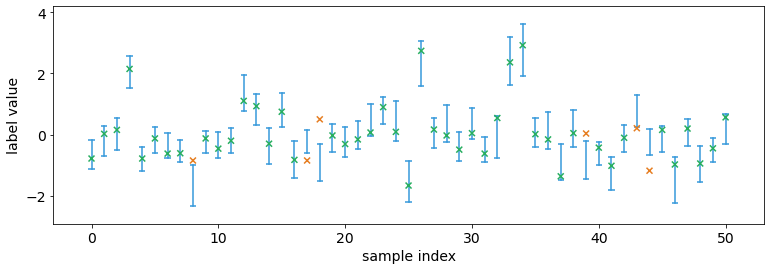

In [3]:
from torchuq.evaluate import interval
interval.plot_interval_sequence(test_intervals, test_labels)

There is an argument called ``coverage`` when creating the ConformalIntervalPredictor class. If you choose ``coverage=exact`` then the intervals have perfectly correct coverage in expectation (the probability that the label belongs to a predicted interval is *exactly* equal to ``confidence``). If you choose ``coverage=1/N`` then the coverage is $0.9 \pm 1/N$ where $N$ is the number of validation samples. 

What's the trade-off? Typically you get smaller intervals if ``coverage=1/N`` compared to ``coverage=exact``. For example, the following code uses ``coverage=1/N`` and the intervals are smaller. In fact, if you use ``coverage=exact`` and have less than `1/confidence` validation samples, the calibrator might predict an infinitely large interval and output $[-\infty, +\infty]$. On the other hand, if you choose ``coverage=1/N`` then the calibrator will never predict an infinitely large interval.

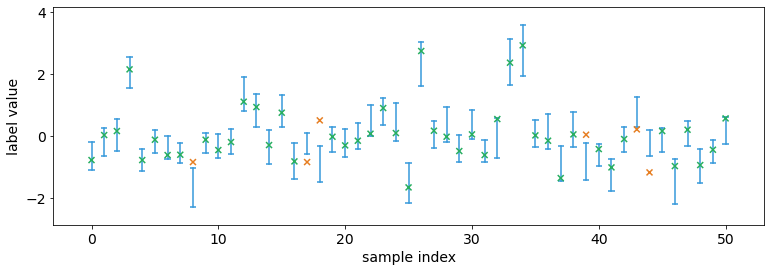

In [4]:
calibrator = ConformalIntervalPredictor(input_type='quantile', coverage='1/N')
calibrator.train(val_preds, val_labels)
test_intervals = calibrator(test_preds, confidence=0.9)
interval.plot_interval_sequence(test_intervals, test_labels)

We used quantile predictions as an example. Note that we could use any prediction type as input. The following example uses point predictions

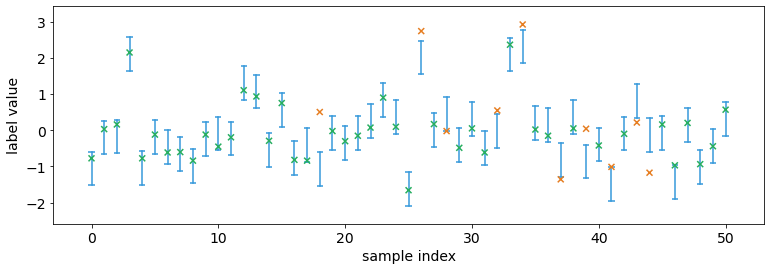

In [5]:
# Split the data into validation and test, in this example we will use quantile predictions as the original predictions
val_preds = reader['predictions_point'][:50]
test_preds = reader['predictions_point'][50:]
calibrator = ConformalIntervalPredictor(input_type='point', coverage='1/N')   # The only difference from before is that the input_type is different
calibrator.train(val_preds, val_labels)
test_intervals = calibrator(test_preds, confidence=0.9)
interval.plot_interval_sequence(test_intervals, test_labels)

## 2. Online Conformal Prediction

In many applications, the data come in as a continuous stream. For example, we might make a prediction every day for tomorrow's weather. After predicting tomorrow's weather, we observe the true label before making a prediction for the-day-after-tomorrow's weather. Torchuq supports this mode of prediction as well. 

To make online predictions, the only new function you will need to know is ``calibrator.update(predictions, labels)``. This functions works almost identically as ``calibrator.train`` except it keeps the previous validation data, while ``calibrator.train`` removes all validation data and starts anew. The following example shows how to make online predictions. 

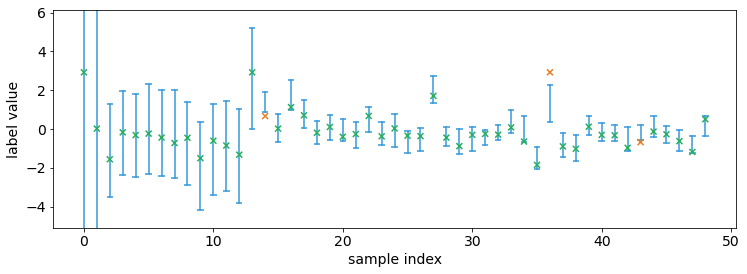

In [6]:
calibrator = ConformalIntervalPredictor(input_type='quantile', coverage='exact')

val_preds = reader['predictions_quantile'][:50]
val_labels = reader['labels'][:50]   # Load the true label (i.e. the ground truth housing prices)

def simulate_online(calibrator):
    # There needs to be at least 1 data point before making any prediction 
    calibrator.train(val_preds[0:1], val_labels[0:1])

    prediction_history = []
    for t in range(1, 50): 
        test_interval_t = calibrator(val_preds[t:t+1], confidence=0.9)  # Make a prediction for the new time step
        calibrator.update(val_preds[t:t+1], val_labels[t:t+1])   # Update the calibrator based on the observed label
        
        prediction_history.append(test_interval_t)

    # Concat the interval predictions for plotting 
    prediction_history = torch.cat(prediction_history)
    return prediction_history

prediction_history = simulate_online(calibrator)
interval.plot_interval_sequence(prediction_history, val_labels[1:50])

Notably initially when there are very few observed data points, the intervals are very large. This is because we selected ``coverage='exact'``. If we do not require exact coverage then the interval sizes can be much smaller. 

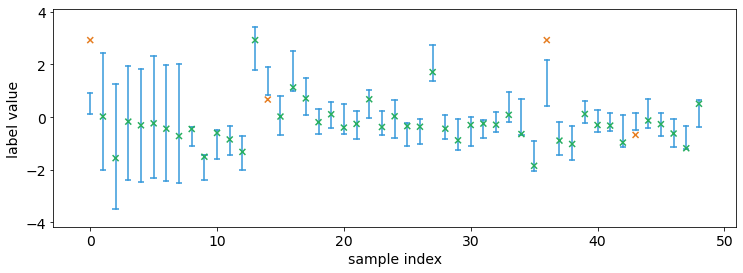

In [7]:
calibrator = ConformalIntervalPredictor(input_type='quantile', coverage='1/N')

prediction_history = simulate_online(calibrator)
interval.plot_interval_sequence(prediction_history, val_labels[1:50])

In fact, torchuq supports even more general prediction problems. For example, we might make a prediction for the weather 7 days from today. We will only observe the true label after 7 predictions. This is often called online learning with delayed feedback. This can be achieved by calling the ``calibrator.update`` function when the feedback arrives. 